# Predicting human wine taste preferences, Part 2

# Adjusting the Model

To recap, our model has a micro precission of 97.55%. In this part we will see if we can make it better.

Improving a Machine Learning model means doing one of these three things:

- Gathering more data: This should be the default solution to every improvement. Gathering more data is almost always much more time efficient than the two other options.
- Adjusting Hyperparameters (we investigate in this post)
- Building a new model altogether

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

sns.set()

# From previous Notebook

Data preprocessing has already been taken care of.

In [2]:
features = pd.read_csv("data\winequality.csv")
print("We have {} samples and {} features".format(*features.shape))

# Split the data into features and classes
labels = features['quality']
features.drop('quality', axis=1, inplace=True)

# Train-Test data for the ML algorithm
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                test_size=0.2, random_state=1, stratify=labels)
print("Shape of Train features:", train_features.shape)
print("Shape of Train labels:", train_labels.shape)
print("Shape of Test features:", test_features.shape)
print("Shape of Test labels:", test_labels.shape)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(train_features, train_labels);

We have 4898 samples and 12 features
Shape of Train features: (3918, 11)
Shape of Train labels: (3918,)
Shape of Test features: (980, 11)
Shape of Test labels: (980,)


As an evaluation metric we will use confusion matrix on which we will compute the tolerance micro precision.
Tolerance precision means that we accept responses that are correct within one of the two nearest classes. 

$ MicroP = \frac{TP}{(TP+FP)} $

In [3]:
def evaluate_model(model, test_features, test_labels):
    """ Evaluate the model using the test features and test labels and then calculate
        tolerance precision as defined on the paper. 
        
        Arguments:
            model: the model to evaluate
            test_features: the test features
            test_labels: the test labels
    """
    
    # Test the model
    predictions = model.predict(test_features)
    
    # Evaluate the model
    confusion_mat = confusion_matrix(test_labels, predictions)
    
    # Calculate tolerance micro precision
    sumTp = 0
    sumTpFp = sum(sum(confusion_mat))

    for i in range(len(confusion_mat)):
        for j in range(len(confusion_mat)):
        
            # element in main diagonal
            if (i == j):
                sumTp += confusion_mat[i][j]

            # element around main diagonal
            elif (j == i+1) & (i<5):
                sumTp += confusion_mat[i][j]

            elif (j == i-1) & (i>0):
                sumTp += confusion_mat[i][j]
                
    microP = sumTp/sumTpFp
    print("Tolerance precision:", round(100*microP, 2))

### Feature Importances

Tolerance precision: 97.55


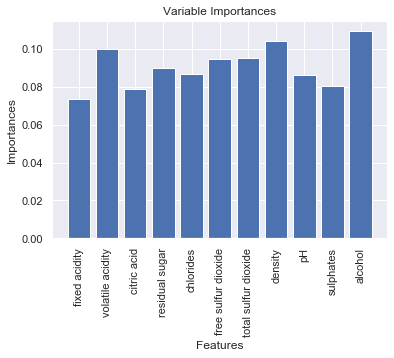

In [4]:
# Base model precision
evaluate_model(rf, test_features, test_labels)

# Calulate variable importances
importances = list(rf.feature_importances_)

# plot
plt.bar(list(features.columns), importances)
plt.xticks(rotation='vertical')
plt.xlabel("Features"); plt.ylabel("Importances"); plt.title("Variable Importances"); plt.show()

Again, we can see that these features are pretty much on the same level and there are little differences. Let's confirm this for sure.

# Exploring possible model improvement: Build a model with the top 5 features.

We already saw that the variables have equal importance but lets try to build a model only with the 5 most important features and lets see how it fares

In [5]:
# Pick the top 4 features
best_feat_train = train_features[['alcohol', 'volatile acidity', 'density', 'free sulfur dioxide', 
                                                                                      'residual sugar']]
best_feat_test = test_features[['alcohol', 'volatile acidity', 'density', 'free sulfur dioxide', 
                                                                       'residual sugar']]
best_feat_rf = RandomForestClassifier(n_estimators=100, random_state=1)

# Train the model
best_feat_rf.fit(best_feat_train, train_labels)

# Test the model
evaluate_model(best_feat_rf, best_feat_test, test_labels)

Tolerance precision: 96.22


We can see that all our features are important for the model because our precision decreased (although slightly). However, **ML is a field of trade-offs** (bias-variance most notably) and one such trade off is the performance-time trade-off. Often a small decrease in performance leads to an disproportionate improvement in run-time which might be crucial for production. We now investigate this trade-off.

## Compare run-time and performance trade-off

In [6]:
# Run time for all features model
all_features_time = []

# Do 20 iterations and take the average of all features
temp_rf = RandomForestClassifier(n_estimators=100, random_state=1)
for _ in range(20):
    start_time = time.time()
    temp_rf.fit(train_features, train_labels)
    predictions = temp_rf.predict(test_features)
    all_features_time.append(time.time()-start_time)
    
print("All features run-time:", round(np.mean(all_features_time), 2))

# Run time for best features model
best_features_time = []

for _ in range(20):
    start_time = time.time()
    temp_rf.fit(best_feat_train, train_labels)
    predictions = temp_rf.predict(best_feat_test)
    best_features_time.append(time.time()-start_time)
    
print("Best features run-time:", round(np.mean(best_features_time), 2))

All features run-time: 0.74
Best features run-time: 0.62


### Accuracy vs Run-time

In [7]:
comparison = pd.DataFrame({
    'features': ['all (11)', 'reduced(5)'],
    'accuracy': ['97.55%', '96.22%'],
    'run_time': ['0.81', '0.63']
})
comparison

,features,accuracy,run_time
0,all (11),97.55%,0.81
1,reduced(5),96.22%,0.63


In [8]:
print("Decrease in accuracy: ", round(100*(1- 96.22/97.55), 2), "%")
print("Decrease in runtime: ", round(100*(1- 0.63/0.81),2), "%")

Decrease in accuracy:  1.36 %
Decrease in runtime:  22.22 %


Now, obviously a run time of *0.81s* and *0.63s* is inconsequential in our case but in a real world scenario, a decrease of *1.36%* in accuracy can be worthwhile when compared with a disporpotenate decrease of *22.22%* in run-time.

# Hyperparameter tuning

Now we turn to the nitty-gritty aspect of this notebook, *hyperparameter tuning*. If we cannot get any more data and no feature engineering is possible then we can turn to hyperparameter tuning in order to boost our model.

At this point in time, the implementations of popular ML algorithms by scikit-learn are state-of-the-art. Thus they come with a whole bunch of settings to adjust, which have a whole theory behind them (another reason to study the ML algorithms themself in addition to the fact that you also won't take them for black magic!). Hyperparameters are set by the Machine Learning engineer before training. Tuning hyperparameters essentially is a trial-and-error process.

They rely more on experimental results than theory and thus the best method to determine the optimal settings is to try many different combinations. One way to realize this is to use Cross Validation (CV). 

In CV we further split the training set into K number of subsets called folds. We then iteratively fit the model K times, each time training the data on K-1 folds and evaluating it on the K-th fold. For hyperparameter tunning we perform many iterations of the entire K-fold CV process, using each time different model settings. Finally, we pick the best model, train it on the full training set and then evaluate on the testing set (as usual). 

In [9]:
# Hyperparameters as they are currently in use by the forest
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) explaining it

There are many different hyperparameters. We shall work with the following:

- n_estimators: number trees in the forest
- max_features: the number of features to consider when looking for the best split
- max_depth: max depth of the tree
- min_samples_split: the minimum number of samples required for the node to be split
- min_samples_leaf: min number of samples required to be at a leaf node
- bootstrap: random forests consist of two randomizing processes. If this is False, then the whole dataset is used to build each tree.

Following: Hyperparameter tuning using Scikit-Learn's [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). We define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

In [27]:
# Number of trees in our forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider when looking for the best split
max_features = ['auto', 'log2']

# max_depth
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_depth.append(None)

# min_samples split
min_samples_split = [2, 4, 9]

# min_samples leaf
min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 4, 9],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


So the algorithm will choose a different set of features out of a total pool of 3600 different settings.

In [28]:
rf2 = RandomForestClassifier()

# n_iter: number of parameter settings that are sampled, in this case 100 out of 3600
# scoring: method of evaluating the predictions on the test set
# cv: the cross-validation splitting strategy. 10 for a 10-fold cross validation
# verbose: the higher the more messages
# n_jobs: -1 use all processors to run in paralel
rf2_random = RandomizedSearchCV(estimator=rf2, param_distributions=random_grid,
                               n_iter=100, scoring='neg_mean_absolute_error',
                               cv=3, verbose=2, random_state=3, n_jobs=-1)

rf2_random.fit(train_features, train_labels);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.8min finished


In [48]:
rf2_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [47]:
# Evaluate current model
evaluate_model(rf, test_features, test_labels)

# Evaluate best random method by RandomizedSearchCV
evaluate_model(rf2_random.best_estimator_, test_features, test_labels)

Tolerance precision: 97.55
Tolerance precision: 97.76


Use [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) to further check the best model. Unlike RandomisedSearch, grid search will try out all combinations.

In [49]:
# Trying out 200 more setting combinations
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60, 70],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [300, 400, 500, 700]
}

rf3 = RandomForestClassifier()

rf3_grid = GridSearchCV(estimator=rf3, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
rf3_grid.fit(train_features, train_labels)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 22.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [51]:
rf3_grid.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [54]:
# Evaluate current model
evaluate_model(rf, test_features, test_labels)

# Evaluate best random method by RandomizedSearchCV
evaluate_model(rf2_random.best_estimator_, test_features, test_labels)

# Evaluate best method by GridSearchCV
evaluate_model(rf3_grid.best_estimator_, test_features, test_labels)

Tolerance precision: 97.55
Tolerance precision: 97.76
Tolerance precision: 97.35


We get diminishing returns.

We took our model from a *97.55%* accuracy to *97.76%* which is unimpressive and a very slight improvement but it is something nonetheless.

# Conclusion

We build a complete end-to-end Machine Learning example going through the process of analysing the data, preparing it for the ML model and then performance evaluation where we even managed to boost it up a little bit!